# Monte Carlo simulations of directed Bayesian network

## Introduction

This Python Jupyter notebook explores a method to simulate samples from a directed Bayesian network where the root nodes are fully observed.

- Vertex class
    - contains a list of samples
- Parent class (sub class of Vertex)
    - root vertex
    - defined by a prior
- Child class (sub class of Vertex)
    - defined by a CPT
- Breadth-first approach starting at the root nodes
- Code for a poly-tree, i.e. multiple root nodes

## Sampling from a uniform distribution

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def uniform_sample(lower, upper, size=1):
    """Sample from a uniform distribution in the half-open interval [lower, upper)."""
    
    # Preconditions
    assert isinstance(lower, float), f"Expected a float, got {type(lower)}"
    assert isinstance(upper, float), f"Expected a float, got {type(upper)}"
    assert 0 <= lower < upper <= 1, f"Invalid range: [{lower}, {upper})"
    
    return np.random.uniform(lower, upper, size)

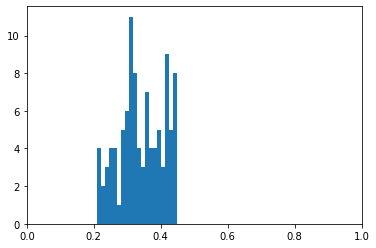

In [3]:
plt.hist(uniform_sample(0.2, 0.45, 100), bins=20)
plt.xlim([0, 1])
plt.show()

In [4]:
def bernoulli_sample(p):
    """Sample from a Bernoulli distribution."""
    
    # Preconditions
    assert isinstance(p, float), f"Expected a float, got {type(p)}"
    assert 0 <= p <= 1
    
    return np.random.binomial(1, p) == 1

In [5]:
np.mean([bernoulli_sample(0.2) for _ in range(1000)])

0.206

In [6]:
def uniform(lower, upper):
    """Returns a function that generates a sample."""
    
    def f():
        return uniform_sample(lower, upper, size=1)[0]
    return f

In [7]:
uniform(0.2, 0.4)()

0.3638647119986338

In [8]:
def bernoulli_from_uniform(lower, upper):
    """Returns a function that generates a Bernoulli sample where its prior is a uniform distribution."""
    
    def f():
        # Sample from a uniform distribution
        p = uniform_sample(lower, upper, size=1)[0]
        
        # Sample from a Bernoulli distribution
        return bernoulli_sample(p)
        
    return f

In [9]:
np.mean([bernoulli_from_uniform(0.3, 0.4)() for _ in range(1000)])

0.36

## One parent, one child


```
a -> b
```

### No observations

In [10]:
prior_a = bernoulli_from_uniform(0.7, 0.9)

cpt_b = {
    True: bernoulli_from_uniform(0.7, 0.8),
    False: bernoulli_from_uniform(0.3, 0.4),
}

In [11]:
n_samples = 1000

samples = {
    "a": [],
    "b": [],
}

for _ in range(n_samples):
    
    # Sample from the prior 'a'
    samples["a"].append(prior_a())
    
    # Sample from 'b'
    b = cpt_b[samples["a"][-1]]()
    samples["b"].append(b)

In [12]:
print(f"Mean of a: {np.mean(samples['a'])}")
print(f"Mean of b: {np.mean(samples['b'])}")

Mean of a: 0.79
Mean of b: 0.658


### Vertex *a* is observed

In [13]:
a = True

n_samples = 1000

samples = {
    "a": [],
    "b": [],
}

for _ in range(n_samples):
    
    # Sample from the prior 'a'
    samples["a"].append(a)
    
    # Sample from 'b'
    b = cpt_b[samples["a"][-1]]()
    samples["b"].append(b)

In [14]:
print(f"Mean of a: {np.mean(samples['a'])}")
print(f"Mean of b: {np.mean(samples['b'])}")

Mean of a: 1.0
Mean of b: 0.777


## Two parents, one child


```
a -> } b
b -> }
```

In [15]:
prior_a = bernoulli_from_uniform(0.7, 0.9)

prior_b = bernoulli_from_uniform(0.6, 0.7)

# a, b
cpt_c = {
    (False, False): bernoulli_from_uniform(0.7, 0.8),
    (False, True): bernoulli_from_uniform(0.4, 0.8),
    (True, False): bernoulli_from_uniform(0.4, 0.5),
    (True, True): bernoulli_from_uniform(0.7, 0.9),
}

In [16]:
n_samples = 1000

samples = {
    "a": [],
    "b": [],
    "c": [],
    
}

for _ in range(n_samples):
    
    # Sample from the priors 'a' and 'b'
    samples["a"].append(prior_a())
    samples["b"].append(prior_b())
    
    # Sample from 'b'
    t = (samples['a'][-1], samples['b'][-1])
    c = cpt_c[t]()
    samples["c"].append(c)

In [17]:
print(f"Mean of a: {np.mean(samples['a'])}")
print(f"Mean of b: {np.mean(samples['b'])}")
print(f"Mean of c: {np.mean(samples['c'])}")

Mean of a: 0.808
Mean of b: 0.652
Mean of c: 0.68


## Generic model

A generic model is where arbitrary vertices can be defined and connected.

In [18]:
import abc

In [19]:
class Vertex(metaclass=abc.ABCMeta):
    
    def __init__(self, name):
        assert isinstance(name, str), f"Expected a str, got {type(name)}"
        assert len(name) > 0, f"Got an empty name"
        assert name != "p", "'p' is a reserved name"
        
        self.name = name    # Name of the vertex
        self.samples = []   # Samples generated by the inference
        
        self.parents = []   # Parent vertices        
        self.children = []  # Child vertices
        
        # Flags used for toplogical sorting
        self.permanent_mark = False
        self.temporary_mark = False        
        
    def clear_samples(self):
        self.permanent_mark = False
        self.temporary_mark = False
        self.samples = []
        
    def add_child(self, child):
        """Add a child vertex."""
        
        if child not in self.children:
            self.children.append(child)
            
        if self not in child.parents:
            child.add_parent(self)
        
    @abc.abstractmethod
    def sample():
        """Generate a sample."""
        pass
    
    def current_sample(self):
        """Get the current sample value."""
        
        return self.samples[-1]

    def summarise(self):
        """Summarise the samples."""
        
        return [np.mean(self.samples), np.std(self.samples)]

In [20]:
class ParentVertex(Vertex):
    def __init__(self, name, prior):
        
        super().__init__(name)
        self.prior = prior
        
        self.observation = None  # None => not observed
    
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        return f"{self.name}"
    
    def clear_observation(self):
        self.observation = None
    
    def sample(self):
        """Generate a sample from the prior."""
        
        if self.observation is not None:
            self.samples.append(self.observation)
        else:
            self.samples.append(self.prior())
    
    def set_observation(self, obs):
        """Set the vertex to be observed."""
        
        assert isinstance(obs, bool)
        self.observation = obs

In [21]:
class ChildVertex(Vertex):
    def __init__(self, name, cpt):
        
        assert isinstance(cpt, list), f"Expected a list, got {type(cpt)}"
        assert len(cpt) > 0
        
        super().__init__(name)
        self.cpt = cpt

    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        return f"{self.name}"
    
    def parent_vertices_from_cpt(self):
        """Get a set of the parent vertex names from the CPT."""
        
        parent_vertex_names = None
        
        for row in self.cpt:
            
            # Set of keys in the dict
            k = set(row.keys())
            
            # Remove the 'p' key as that is for the probability distribution
            assert 'p' in k
            k.remove('p')
            
            if parent_vertex_names is None:
                parent_vertex_names = k
            else:
                assert parent_vertex_names == k, f"Inconsistent parent vertex names"
            
        return parent_vertex_names
    
    def add_parent(self, parent):
        """Add a parent vertex."""
        
        if parent not in self.parents:
            self.parents.append(parent)
        
        if self not in parent.children:
            parent.add_child(self)
            
    def parent_values(self):
        """Get a dict of the samples from this vertex's parents."""
        
        # Preconditions
        assert len(self.parents) > 0
        
        return {v.name: v.current_sample() for v in self.parents}
        
    def input_values_same(self, cpt_row, parent_values):
        
        assert isinstance(parent_values, dict), f"Expected a dict, got {type(parent_values)}"
        
        for key, value in parent_values.items():
            if cpt_row[key] != value:
                return False
            
        return True
        
    def find_entry_in_cpt(self, parent_values):
        """Find the entry from the CPT given the parent samples."""
        
        assert isinstance(parent_values, dict), f"Expected a dict, got {type(parent_values)}"
        
        for entry in self.cpt:
            if self.input_values_same(entry, parent_values):
                return entry
        
        return None
        
    def sample(self):
        """Generate a sample."""
        
        # Get a dict of values from the parent vertices
        p = self.parent_values()
        
        # Find the CPT entry
        row = self.find_entry_in_cpt(p)
        
        # Generate the sample
        sample = row["p"]()
        
        self.samples.append(sample)

In [22]:
def get_vertex_without_permanent_mark(list_vertices):
    """Get a vertex from a list of vertices that doesn't have a permanent mark."""
    
    assert isinstance(list_vertices, list)
    assert len(list_vertices) > 0
    
    for v in list_vertices:
        if not v.permanent_mark:
            return v
    
    return None

In [23]:
def visit(vertex, L):
    
    if vertex.permanent_mark:
        return
    
    if vertex.temporary_mark:
        raise Exception("Not a DAG")
        
    # Mark the vertex
    vertex.temporary_mark = True
    
    for child_vertex in vertex.children:
        visit(child_vertex, L)
    
    # Remove the temporary mark
    vertex.temporary_mark = False
    
    # Mark the vertex with a permanent mark
    vertex.permanent_mark = True
    
    # Add the vertex to the head of the list L
    L.insert(0, vertex)

In [24]:
def calc_execution_order(list_vertices):
    
    L = []  # Empty list that will contain sorted nodes
    
    vertex_without_permanent_mark = get_vertex_without_permanent_mark(list_vertices)
    
    while vertex_without_permanent_mark is not None:

        # Visit the vertex
        visit(vertex_without_permanent_mark, L)
        
        # Get the next vertex without a permanent mark
        vertex_without_permanent_mark = get_vertex_without_permanent_mark(list_vertices)
    
    return L

In [25]:
def generate_samples(list_vertices, n_samples):
    
    # Determine the execution order
    execution_order = calc_execution_order(list_vertices)
    
    # Generate the samples
    for _ in range(n_samples):
        for vertex in execution_order:
            vertex.sample()

    # Build a dict of vertex to probability
    vertex_to_prob = {}
    for vertex in execution_order:
        assert len(vertex.samples) == n_samples
        vertex_to_prob[vertex.name] = vertex.summarise()
    
    return vertex_to_prob

In [26]:
def build_root_vertex(vertex_config):
    """Build a root vertex given the parsed JSON config."""
    
    # Preconditions
    assert isinstance(vertex_config, dict), f"Expected a dict, got {type(vertex_config)}"
    assert "name" in vertex_config
    assert "p" in vertex_config
    assert len(vertex_config["p"]) == 2
    
    # Extract the name of the vertex
    name = vertex_config["name"]
    
    # Extract the prior
    lower_bound, upper_bound = vertex_config["p"]
    assert lower_bound < upper_bound
    
    return ParentVertex(name, bernoulli_from_uniform(lower_bound, upper_bound))

In [27]:
def build_child_vertex(vertex_config):
    """Build a child vertex given the parsed JSON config."""
    
    # Preconditions
    assert isinstance(vertex_config, dict), f"Expected a dict, got {type(vertex_config)}"
    assert "name" in vertex_config
    assert "cpt" in vertex_config
    
    # Extract the name of the vertex
    name = vertex_config["name"]
    
    # Build the CPT
    cpt = []
    for row in vertex_config["cpt"]:
        
        parsed_row = {name: value for name, value in row.items() if name != "p"}
        
        # Extract the probability distribution
        lower_bound, upper_bound = row["p"]
        assert lower_bound < upper_bound
        
        parsed_row["p"] = bernoulli_from_uniform(lower_bound, upper_bound)
        
        cpt.append(parsed_row)
    
    return ChildVertex(name, cpt)

In [28]:
def find_vertex_given_name(list_vertices, name):
    """Get a vertex from a list given the vertex's name."""
    
    # Preconditions
    assert isinstance(list_vertices, list), f"Expected a list, got {type(list_vertices)}"
    assert isinstance(name, str), f"Expected a str, got {type(name)}"
    
    for vertex in list_vertices:
        if vertex.name == name:
            return vertex
    
    return None

In [29]:
def build_vertices_from_json(j):
    """Build a list of vertices from JSON configuration."""
    
    # Preconditions
    assert isinstance(j, dict), f"Expected a dict, got {type(j)}"
    
    list_vertices = []
    
    for vertex_config in j["vertices"]:
        
        # Determine the type of vertex from a field that should be present
        if 'p' in vertex_config:
            vertex = build_root_vertex(vertex_config)
        else:
            vertex = build_child_vertex(vertex_config)
        
        list_vertices.append(vertex)
        
    # Connect up child vertices
    for vertex in list_vertices:
        
        if type(vertex) == ChildVertex:
            parent_vertex_names = vertex.parent_vertices_from_cpt()
            
            for parent_name in parent_vertex_names:
                parent_vertex = find_vertex_given_name(list_vertices, parent_name)
                assert parent_vertex is not None
                
                parent_vertex.add_child(vertex)
        
    # Postconditions
    assert len(list_vertices) == len(j["vertices"])
    
    return list_vertices

In [30]:
def get_root_vertices(list_vertices):
    
    # Preconditions
    assert isinstance(list_vertices, list), f"Expected a list, got {type(list_vertices)}"
    
    root_vertices = []
    
    for vertex in list_vertices:
        if type(vertex) == ParentVertex:
            root_vertices.append(vertex)
        
    return root_vertices

In [31]:
def add_input(p=None):
    """Add another input to a defined binary table."""
    
    if p == None:
        return [[False], [True]]
    else:
        
        r = []
        for start in [False, True]:
            for row in p:
                row_copy = row[:]
                row_copy.insert(0, start)
                r.append(row_copy)
            
        return r
    
# Tests
assert add_input() == [[False], [True]]
assert add_input([[False], [True]]) == [
    [False, False], 
    [False, True], 
    [True, False], 
    [True, True]]

In [32]:
def generate_combinations(n):
    """Generate all of the possible binary inputs for a function with n inputs."""
    
    assert isinstance(n, int)
    assert n > 0
    
    r = add_input()
    
    for i in range(1,n):
        r = add_input(r)
    
    return r

assert generate_combinations(1) == [[False], [True]]
assert generate_combinations(2) == [[False, False], [False, True], [True, False], [True, True]]

In [33]:
def calc_lookup_table_entry(list_vertices, inputs, n_samples):
    """Calculate the probabilities of each vertex given a dict of inputs."""
    
    # Preconditions
    assert isinstance(list_vertices, list), f"Expected a list, got {type(list_vertices)}"
    assert isinstance(inputs, dict), f"Expected a dict, got {type(inputs)}"
    assert isinstance(n_samples, int), f"Expected an int, got {type(n_samples)}"
    assert n_samples > 0
    
    # Clear down the samples and observations (if the vertex is a parent)
    for v in list_vertices:
        v.clear_samples()
        
        if type(v) == ParentVertex:
            v.clear_observation()
        
    # Set the observations
    for name, value in inputs.items():
        v = find_vertex_given_name(list_vertices, name)
        assert v is not None
        
        v.set_observation(value)
    
    # Run the inference
    result = generate_samples(list_vertices, n_samples)
    
    assert len(result) > 0, "Dict of samples is empty"
    
    return result

In [34]:
def build_lookup_table(list_vertices, n_samples):
    """Build a lookup table given a network."""
    
    # Preconditions
    assert isinstance(list_vertices, list), f"Expected a list, got {type(list_vertices)}"
    assert isinstance(n_samples, int), f"Expected an int, got {type(n_samples)}"
    assert n_samples > 0
    
    # Get a list of the root vertices
    root_vertices = get_root_vertices(list_vertices)
    
    root_vertex_names = [v.name for v in root_vertices]
    
    # Generate all of the input combinations
    input_combinations = generate_combinations(len(root_vertices))
    
    # Initialise the lookup table
    lookup_table = []
    
    for row in input_combinations:
        
        # Create a dict of the input combinations to their values
        inputs = dict(zip(root_vertex_names, row))
        
        # Calculate all of the probabilities
        outputs = calc_lookup_table_entry(list_vertices, inputs, n_samples)
        
        entry = {
            "inputs": inputs,
            "outputs": outputs
        }
        
        lookup_table.append(entry)
        
    return lookup_table

In [35]:
config = {
    "vertices": [
        {
            "name": "a",
            "p": [0.7, 0.8]
        },
        {
            "name": "b",
            "p": [0.2, 0.4]
        },        
        {
            "name": "c",
            "cpt": [
                {"a": False, "b": False, "p": [0.2, 0.3]},
                {"a": False, "b": True, "p": [0.3, 0.4]},
                {"a": True, "b": False, "p": [0.3, 0.4]},
                {"a": True, "b": True, "p": [0.3, 0.4]},
            ]
        }
    ]
}

In [36]:
vertices = build_vertices_from_json(config)
vertices

[a, b, c]

In [37]:
build_lookup_table(vertices, n_samples=10000)

[{'inputs': {'a': False, 'b': False},
  'outputs': {'b': [0.0, 0.0],
   'a': [0.0, 0.0],
   'c': [0.2428, 0.42877518584918134]}},
 {'inputs': {'a': False, 'b': True},
  'outputs': {'b': [1.0, 0.0],
   'a': [0.0, 0.0],
   'c': [0.3427, 0.4746121679856091]}},
 {'inputs': {'a': True, 'b': False},
  'outputs': {'b': [0.0, 0.0],
   'a': [1.0, 0.0],
   'c': [0.3425, 0.4745458355101222]}},
 {'inputs': {'a': True, 'b': True},
  'outputs': {'b': [1.0, 0.0],
   'a': [1.0, 0.0],
   'c': [0.3475, 0.4761761753804993]}}]

In [38]:
a = ParentVertex("a", bernoulli_from_uniform(0.7, 0.8))
a.set_observation(True)

b = ChildVertex("b", [
    {"a": True, "p": bernoulli_from_uniform(0.2, 0.3)},
    
        {"a": False, "p": bernoulli_from_uniform(0.3, 0.4)},
])
a.add_child(b)

c = ChildVertex("c", [
    {"b": True, "p": bernoulli_from_uniform(0.2, 0.3)},
    {"b": False, "p": bernoulli_from_uniform(0.3, 0.4)},    
])
b.add_child(c)

generate_samples([a,b,c], 100)

{'a': [1.0, 0.0],
 'b': [0.12, 0.3249615361854384],
 'c': [0.29, 0.4537620521815371]}